In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


import mlflow
import mlflow.tensorflow
import tempfile

SEED = 22
np.random.seed(SEED)
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prantobosu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:

df = pd.read_csv("/Users/prantobosu/Documents/SMS-detection/sms-spam-detection-with-machine-learning/spam.csv", encoding="latin-1")

df = df[['v1', 'v2']]
df.columns = ['label', 'message']

df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("Dataset shape:", df.shape)
print("First 5 rows:")
print(df.head())


print("Missing values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

print("Class distribution:")
print(df['label'].value_counts())

Dataset shape: (5572, 2)
First 5 rows:
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
Missing values:
 label      0
message    0
dtype: int64
Duplicate rows: 403
Class distribution:
label
0    4825
1     747
Name: count, dtype: int64


In [11]:

SEED = 42  

def clean_text(text):
    """
    Clean the input text by converting to a string (if not already),
    lowering the case, removing non-alphabetical characters,
    and ensuring messages are not completely removed.
    """
    if not isinstance(text, str):
        text = str(text) if pd.notnull(text) else ""  
    text = text.lower()
    
   
    text = re.sub(r'[^a-z0-9\s]', '', text)  

    return text.strip() if text.strip() else "empty"  

df['clean_message'] = df['message'].apply(clean_text)


X = df['clean_message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)


print("Class distribution before filtering:\n", y_train.value_counts())

X_train = X_train.apply(lambda x: "empty" if x.strip() == "" else x)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print("Class distribution after filtering:\n", y_train.value_counts())

if y_train.nunique() == 1:
    print("Error: Only one class remains after filtering. Adjust cleaning logic.")


Class distribution before filtering:
 label
0    3859
1     598
Name: count, dtype: int64
Class distribution after filtering:
 label
0    3859
1     598
Name: count, dtype: int64


Naive Bayes Performance:
Accuracy: 0.9757847533632287
Precision: 0.9121621621621622
Recall: 0.9060402684563759
F1 Score: 0.9090909090909091
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.91      0.91      0.91       149

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



/Users/prantobosu/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


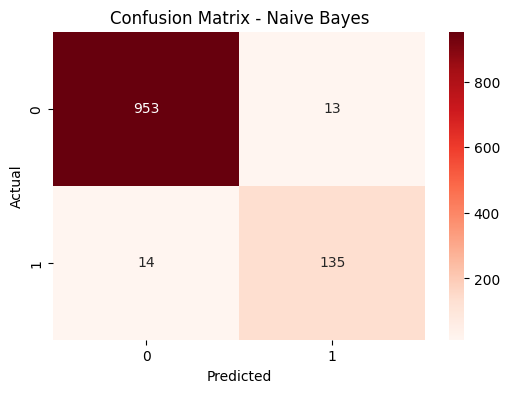

In [12]:

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

smote = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = smote.fit_resample(X_train_tfidf, y_train)

NB_model = MultinomialNB()
NB_model.fit(X_train_bal, y_train_bal)


y_pred_NB = NB_model.predict(X_test_tfidf)

print("Naive Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_NB))
print("Precision:", precision_score(y_test, y_pred_NB))
print("Recall:", recall_score(y_test, y_pred_NB))
print("F1 Score:", f1_score(y_test, y_pred_NB))
print("Classification Report:\n", classification_report(y_test, y_pred_NB))

cm = confusion_matrix(y_test, y_pred_NB)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



Logistic Regression Performance:
Accuracy: 0.979372197309417
Precision: 0.9315068493150684
Recall: 0.912751677852349
F1 Score: 0.9220338983050848
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.91      0.92       149

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



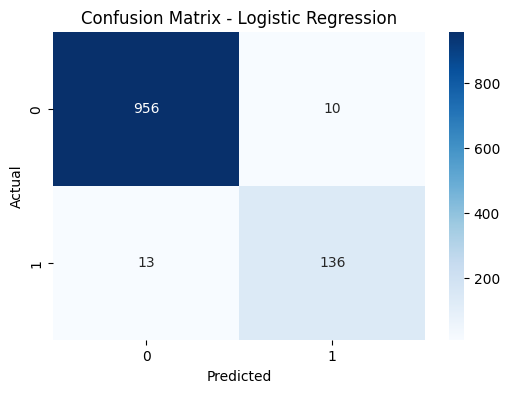

In [13]:

log_reg = LogisticRegression(random_state=SEED, max_iter=500)
log_reg.fit(X_train_bal, y_train_bal)

y_pred_lr = log_reg.predict(X_test_tfidf)


print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:

max_words = 5000  
max_len = 100 
embaddung_dim = 16 


tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['message'])

sequences = tokenizer.texts_to_sequences(df['message'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
X = padded_sequences
y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embaddung_dim),
    Bidirectional(LSTM(64, return_sequences=True)),  
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))

model.summary()

history = model.fit(X_train, y_train,
                    epochs=5, batch_size=32
                    , validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 16)        │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 128)       │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,745 (639.63 KB)

 Trainable params: 163,745 (639.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.7184 - loss: 0.4847 - val_accuracy: 0.9731 - val_loss: 0.1161
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.9853 - loss: 0.0991 - val_accuracy: 0.9848 - val_loss: 0.0547
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9851 - loss: 0.0530 - val_accuracy: 0.9865 - val_loss: 0.0597
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.9966 - loss: 0.0257 - val_accuracy: 0.9821 - val_loss: 0.0684
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.9974 - loss: 0.0154 - val_accuracy: 0.9839 - val_loss: 0.0771


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
LSTM Model Performance:
Accuracy: 0.9838565022421525
Precision: 1.0
Recall: 0.8791946308724832
F1 Score: 0.9357142857142857
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.88      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



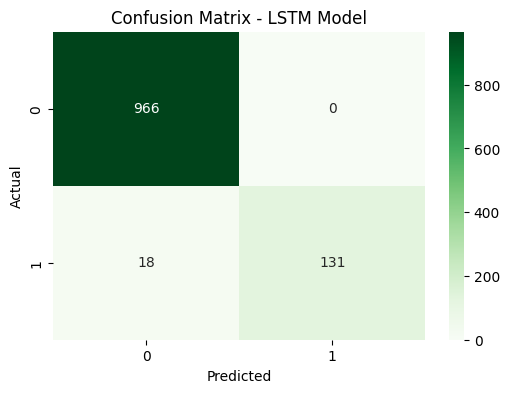

In [15]:

y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("LSTM Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - LSTM Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [16]:

model_save_path = "sms_spam_model.h5"
model.save(model_save_path)

import pickle
tokenizer_save_path = "tokenizer.pkl"
with open(tokenizer_save_path, "wb") as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved successfully.")


Model and tokenizer saved successfully.
